# Import Data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation of the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import pickle

plt.rcParams['font.size'] = 18

In [2]:
train = pd.read_csv('../Dataset/train_small.csv')
test = pd.read_csv('../Dataset/test_small.csv')

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

Train shape:  (307511, 280)
Test shape:  (48744, 279)


# Import model, test and metrics

In [3]:
# Extract the labels
labels = train['TARGET']
features = train.drop(columns=['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.25, random_state=17)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (230633, 278)
Test shape:  (76878, 278)


,CREDIT_TERM,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_payments_AMT_PAYMENT_min_sum,AMT_ANNUITY,client_pos_cash_CNT_INSTALMENT_FUTURE_mean_max,bureau_DAYS_CREDIT_max,...,client_installments_payments_NUM_INSTALMENT_VERSION_sum_sum,previous_NAME_GOODS_CATEGORY_ConsumerElectronics_mean,client_credit_card_AMT_CREDIT_LIMIT_ACTUAL_min_sum,client_credit_card_SK_DPD_mean_min,bureau_CREDIT_ACTIVE_Sold_count_norm,client_bureau_balance_MONTHS_BALANCE_count_max,previous_NAME_CLIENT_TYPE_New_mean,previous_CODE_REJECT_REASON_LIMIT_mean,client_credit_card_AMT_DRAWINGS_ATM_CURRENT_sum_sum,previous_WEEKDAY_APPR_PROCESS_START_TUESDAY_mean
89672,0.102457,0.719170,0.541840,0.472253,-8093.0,16834,65330.550,16137.0,6.818182,-126.0,...,110.0,0.0,NaN,NaN,0.0,36.0,1.0,0.0,NaN,0.0
238736,0.061293,NaN,0.615644,0.185202,-5438.0,15884,31119.480,9252.0,36.000000,-82.0,...,91.0,0.0,NaN,NaN,0.0,9.0,0.5,0.0,NaN,0.0
278307,0.051056,0.391970,0.323001,0.461482,-1551.0,10730,40367.703,41355.0,3.000000,-376.0,...,36.0,0.0,NaN,NaN,0.0,80.0,1.0,0.0,NaN,0.0
181026,0.050000,NaN,0.705380,0.636376,-358.0,15654,162577.530,19125.0,8.000000,-131.0,...,169.0,0.0,NaN,NaN,0.0,NaN,0.5,0.0,NaN,0.0
66008,0.048328,0.656476,0.477630,NaN,-1456.0,19008,68668.160,28530.0,20.000000,NaN,...,81.0,0.5,405000.0,0.0,NaN,NaN,1.0,0.0,668250.0,0.0


In [4]:
with open('Final_Model.pkl', 'rb') as file:
    Final_Model = pickle.load(file)

In [5]:
preds_proba = Final_Model.predict_proba(test_features)[:, 1]
preds = Final_Model.predict(test_features)

rus_auc = roc_auc_score(test_labels, preds_proba)

print('The random undersampling model scores {:.5f} ROC AUC on the test set.'.format(
    rus_auc))
print()
print(classification_report(test_labels, preds))

The random undersampling model scores 0.77660 ROC AUC on the test set.

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     70622
           1       0.18      0.70      0.28      6256

    accuracy                           0.71     76878
   macro avg       0.57      0.70      0.55     76878
weighted avg       0.90      0.71      0.77     76878



# SHAP Values

In [6]:
# use 1 row of data here. Could use multiple rows if desired
data_for_prediction = test_features.iloc[0]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

In [7]:
Final_Model.predict_proba(data_for_prediction_array)

array([[0.8202284, 0.1797716]])

In [8]:
import shap

shap.initjs()

# Create object that can calculate shap values
explainer = shap.TreeExplainer(Final_Model)

In [9]:
shap_values = explainer.shap_values(data_for_prediction_array)
shap.force_plot(explainer.expected_value[1],
                shap_values[1], data_for_prediction)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


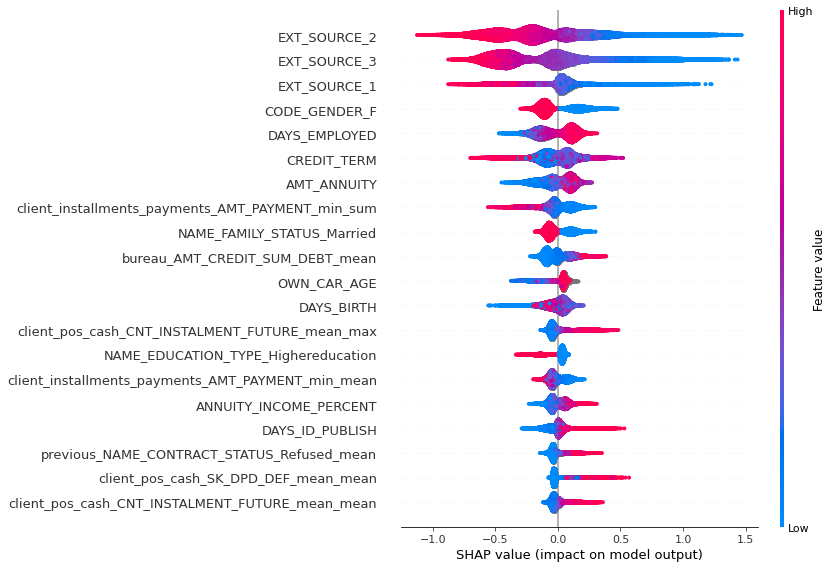

In [10]:
shap_values = explainer.shap_values(test_features)
shap.summary_plot(shap_values[1], test_features)

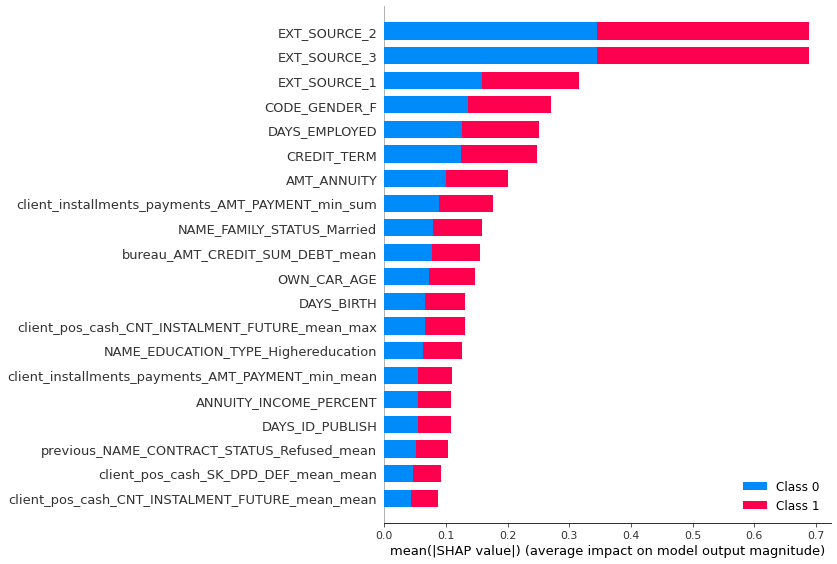

In [11]:
shap.summary_plot(shap_values, test_features)

In [12]:
shap_sum = np.abs(shap_values[0]).mean(axis=0)

importance_df = pd.DataFrame(
    [test_features.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)

importance_df.head(15)

,column_name,shap_importance
2,EXT_SOURCE_2,0.344817
3,EXT_SOURCE_3,0.344753
1,EXT_SOURCE_1,0.158057
18,CODE_GENDER_F,0.135173
4,DAYS_EMPLOYED,0.125279
0,CREDIT_TERM,0.123589
7,AMT_ANNUITY,0.099993
6,client_installments_payments_AMT_PAYMENT_min_sum,0.088477
44,NAME_FAMILY_STATUS_Married,0.079276
15,bureau_AMT_CREDIT_SUM_DEBT_mean,0.077848


In [13]:
most_important_var = importance_df['column_name'][0:5].tolist()
most_important_var

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'CODE_GENDER_F',
 'DAYS_EMPLOYED']

# Save reduced Dataset to upload on Github

In [14]:
# Remove rows with Nan in the most important variables

test.dropna(subset=most_important_var, inplace=True)

In [15]:
reduced_train = train.iloc[:10000, :]
reduced_test = test.iloc[:1000, :]

In [16]:
reduced_train.to_csv('reduced_train.csv', index=False)
reduced_test.to_csv('reduced_test.csv', index=False)